In [1]:
import bilby
import gwmemory
from waveforms import osc_freq_XPHM, mem_freq_XPHM, mem_freq_XPHM_only
import numpy as np

OpenBLAS blas_thread_init: pthread_create failed for thread 47 of 80: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 500 current, 500 max
OpenBLAS blas_thread_init: pthread_create failed for thread 48 of 80: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 500 current, 500 max
OpenBLAS blas_thread_init: pthread_create failed for thread 49 of 80: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 500 current, 500 max
OpenBLAS blas_thread_init: pthread_create failed for thread 50 of 80: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 500 current, 500 max
OpenBLAS blas_thread_init: pthread_create failed for thread 51 of 80: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 500 current, 500 max
OpenBLAS blas_thread_init: pthread_create failed for thread 52 of 80: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 500 current, 500 max
OpenBLAS blas_th

KeyboardInterrupt: 

# Goal: check if the frequnecy array in gwmemory package and my code is defined correctly.

Quick test for ifft

In [ ]:
freq_test = np.linspace(-1024, 1024, 8193)
freq_test = np.roll(freq_test, 4*1024+1)
print(freq_test)

[ 0.    0.25  0.5  ... -0.75 -0.5  -0.25]


Define variables and set up CoupledTimeAndFrequencyArray

In [ ]:
sampling_frequency = 2048
duration = 4
start_time = -2
roll_off = 0.4
minimum_frequency=20
reference_frequency = 20
maximum_frequency= 1024
waveform_name = 'IMRPhenomXPHM'
amplitude = 1

series = bilby.core.series.CoupledTimeAndFrequencySeries(start_time=start_time,
                                                         duration=duration,
                                                         sampling_frequency=sampling_frequency)
print(series.frequency_array)

[0.00000e+00 2.50000e-01 5.00000e-01 ... 1.02350e+03 1.02375e+03
 1.02400e+03]


Set up the waveform generators.

In [ ]:
waveform_generator_osc = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= bilby.gw.source.lal_binary_black_hole,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            waveform_approximant=waveform_name,
                            )

)

waveform_generator_full = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

16:53 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:53 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_v2
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


# Test 1

Check if the bilby waveform generator frequency array is the same as defining as defining CoupleTimeAndFrequencyArray

In [ ]:
frequency_array = waveform_generator_full.frequency_array
print('bilby frequency array: ', frequency_array)
print('my frequency array: ', series.frequency_array)

bilby frequency array:  [0.00000e+00 2.50000e-01 5.00000e-01 ... 1.02350e+03 1.02375e+03
 1.02400e+03]
my frequency array:  [0.00000e+00 2.50000e-01 5.00000e-01 ... 1.02350e+03 1.02375e+03
 1.02400e+03]


Good it is the same.

# Test 2

 Check if replacing the frequency array in CoupledTimeAndFrequencyArray changes the time (and frequency) array appropriately.

In [ ]:
frequency_array = waveform_generator_full.frequency_array
series = bilby.core.series.CoupledTimeAndFrequencySeries(start_time=-2) # make sure start time is indeed -2.
series.frequency_array = frequency_array
print('Coupled time array: ', series.time_array)
print('Compare to bilby time array: ', waveform_generator_full.time_array)
print('Coupled frequency array: ', series.frequency_array)
print('Compare to bilby frequency array: ', waveform_generator_full.frequency_array)

Coupled time array:  [-2.         -1.99951172 -1.99902344 ...  1.99853516  1.99902344
  1.99951172]
Compare to bilby time array:  [0.00000000e+00 4.88281250e-04 9.76562500e-04 ... 3.99853516e+00
 3.99902344e+00 3.99951172e+00]
Coupled frequency array:  [0.00000e+00 2.50000e-01 5.00000e-01 ... 1.02350e+03 1.02375e+03
 1.02400e+03]
Compare to bilby frequency array:  [0.00000e+00 2.50000e-01 5.00000e-01 ... 1.02350e+03 1.02375e+03
 1.02400e+03]


Time array is shifted differently. I don't think this is a cause for concern though.

# Test 3

Check if all the FFT performed on the waveform are valid. This will be a much more involved test as I will have to perform all the FFT.

In [ ]:
import lalsimulation as lalsim
import matplotlib.pyplot as plt
import numpy as np
from gwmemory.utils import combine_modes

solar_mass = 2e30
mpc = 3e22
m1 = 30*solar_mass
m2 = 30*solar_mass

test = np.arange(0, 100, 1)


params = dict(f_min = 20.0,
              f_ref = 20.0,
              phiRef=2,     # lalsim docs specify I must define this parameter as 0
              approximant = lalsim.GetApproximantFromString('IMRPhenomXPHM'),
              LALpars=None,
              m1=m1,
              m2=m2,
              S1x=0,
              S1y=0,
              S1z=0,
              S2x=0,
              S2y=0,
              S2z=0,
              distance= 400*mpc,
              inclination=np.pi/4,
              deltaF = 1/4,
              f_max = 1024,
              )

waveform_modes = lalsim.SimInspiralChooseFDModes(**params)

h_lm = dict()
while waveform_modes is not None:
    mode = (waveform_modes.l, waveform_modes.m)
    data = waveform_modes.mode.data.data[:-1]
    h_lm[mode] = np.roll(data, 4 * params['f_max'])
    #h_lm[mode] = data
    waveform_modes = waveform_modes.next

waveform_modes = lalsim.SimInspiralChooseFDModes(**params)

h_lm2 = dict()
while waveform_modes is not None:
    mode = (waveform_modes.l, waveform_modes.m)
    data = waveform_modes.mode.data.data[:-1]
    h_lm2[mode] = np.roll(data, 4 * params['f_max'])
    #h_lm[mode] = data
    waveform_modes = waveform_modes.next


In [ ]:
freq_test = np.linspace(-1024, 1024, 8193)
freq_test = np.roll(freq_test, 4*1024+1)
print(freq_test[len(freq_test)//2:])

freq_test = np.linspace(-1024, 1024, 8193)
freq_test = np.roll(freq_test[:-1], 4*1024)
print(freq_test[len(freq_test)//2:])

[ 1.02400e+03 -1.02400e+03 -1.02375e+03 ... -7.50000e-01 -5.00000e-01
 -2.50000e-01]
[-1.02400e+03 -1.02375e+03 -1.02350e+03 ... -7.50000e-01 -5.00000e-01
 -2.50000e-01]


In [ ]:
times = np.linspace(0, 4, 8192)
frequency = np.linspace(0, 1024, 4097)

In [ ]:
import lal

def combine_modes_moritz(h_lm, inc, phase):
    """Calculate the plus and cross polarisations of the waveform from the spherical harmonic decomposition."""
    # total = sum([h_lm[(l, m)] * harmonics.sYlm(-2, l, m, inc, phase) for l, m in h_lm])
    total = sum([h_lm[(l, m)] * lal.SpinWeightedSphericalHarmonic(inc, np.pi - phase, -2, l, m) for l, m in h_lm])
    h_plus_cross = dict(plus=total.real, cross=-total.imag)
    return h_plus_cross


{(4, 4): array([-9.21615396e-23-1.26206734e-22j, -1.58940942e-22+3.97328198e-23j,
       -1.31630703e-23+1.63803189e-22j, ...,
        5.98403009e-23+1.23124498e-22j,  1.39144202e-22+8.86004878e-24j,
        7.27325519e-23-1.26996102e-22j]), (4, 3): array([-7.48053125e-27+4.55372370e-27j,  1.78656384e-27+8.79415925e-27j,
        9.21216049e-27+8.83331133e-28j, ...,
        7.34651360e-27-3.80860218e-27j,  8.13784882e-28-8.48807699e-27j,
       -7.13512194e-27-4.89790432e-27j]), (4, 2): array([ 1.67764279e-31+3.01805347e-31j,  3.44506575e-31-4.21693656e-32j,
        6.19749663e-32-3.36862947e-31j, ...,
       -1.41411168e-31-2.77715474e-31j, -3.22051406e-31-3.02178058e-32j,
       -1.91883332e-31+2.76106610e-31j]), (4, 1): array([ 8.83482641e-36-4.44901488e-36j, -8.15555681e-37-9.94832346e-36j,
       -9.62004895e-36-2.32711932e-36j, ...,
       -8.37283742e-36+4.24635173e-36j, -1.20160855e-36+9.49953161e-36j,
        7.74686707e-36+5.90404909e-36j]), (4, 0): array([-1.85367225e-40+1.01

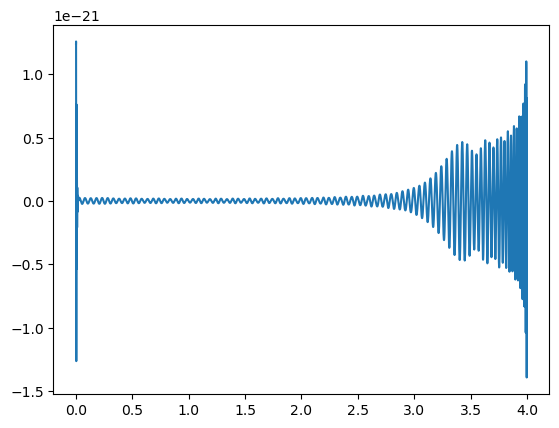

In [ ]:
h_lm_td = {}
for l,m in h_lm:
    mode = (l, m)
    h_lm_td[mode] = np.fft.ifft(h_lm[mode])*2048
print(h_lm_td)
full_waveform = combine_modes(h_lm_td, inc=np.pi/4, phase=0)
print(full_waveform)
plt.figure()
plt.plot(times, full_waveform['plus']-1j*full_waveform['cross'])
plt.savefig('tests/fd_mode_full_wf_time_domain.png')

In [ ]:
full_waveform_fd = {}
for key in full_waveform:
    full_waveform_fd[key]= np.fft.rfft(full_waveform[key])/2048

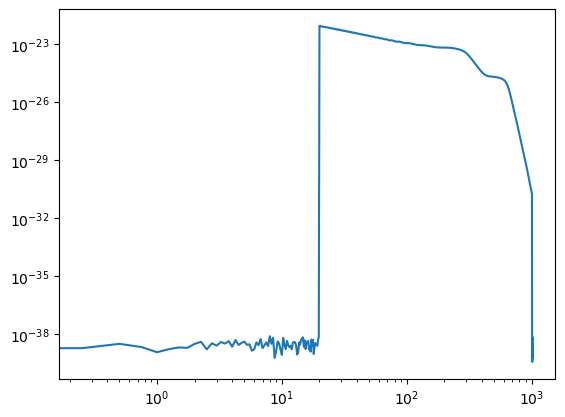

In [ ]:
plt.figure()
plt.loglog(frequency, np.abs(full_waveform_fd['plus']+full_waveform_fd['cross']))
plt.savefig('tests/fd_mode_full_wf_freq_domain.png')

In [ ]:
params = dict(f_min = 20.0,
              f_ref = 20.0,
              approximant = lalsim.GetApproximantFromString('IMRPhenomXPHM'),
              LALpars=None,
              m1=m1,
              m2=m2,
              S1x=0,
              S1y=0,
              S1z=0,
              S2x=0,
              S2y=0,
              S2z=0,
              distance= 400*mpc,
              inclination=np.pi/4,
              deltaF = 1/4,
              f_max = 1024,
              phiRef = 2, 
              meanPerAno = 0.0,
              eccentricity = 0.0,
              longAscNodes = 0.0,
              )

hplus, hcross = lalsim.SimInspiralChooseFDWaveform(**params)

In [ ]:
plusFD = hplus.data.data
crossFD = hcross.data.data

print(len(plusFD))
print(crossFD)

4097
[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


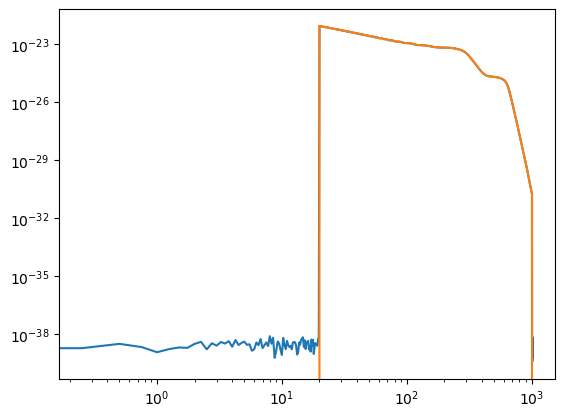

In [ ]:
plt.figure()
plt.loglog(frequency, np.abs(full_waveform_fd['plus']+full_waveform_fd['cross']), label='FDmodes')
plt.loglog(frequency, np.abs(plusFD+crossFD), label='FDwaveform')
#plt.xlim(19, 200)
#plt.ylim(2e-23, 4e-23)
plt.savefig('tests/compare_FDmodes_vs_FDwaveform_fd.png')

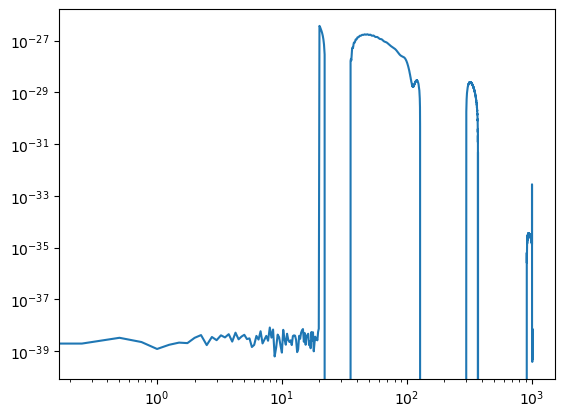

In [ ]:
plt.figure()
plt.loglog(frequency, np.abs(full_waveform_fd['plus']+full_waveform_fd['cross'])-np.abs(plusFD+crossFD), label='difference')
plt.savefig('tests/compare_FDmodes_vs_FDwaveform_difference.png')

/local/shunyin.cheung/ipykernel_2336264/1619114048.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(frequency, np.abs(full_waveform_fd['plus']+full_waveform_fd['cross'])/np.abs(plusFD+crossFD), label='difference')


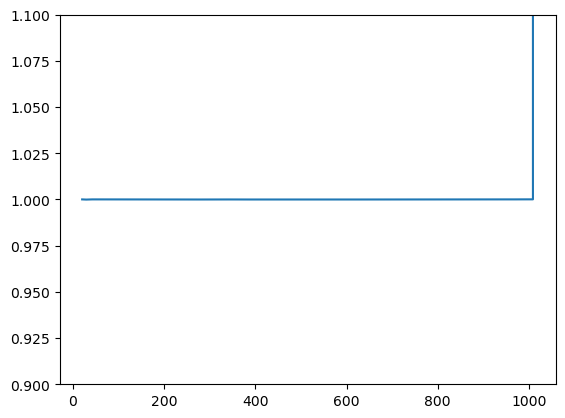

In [ ]:
plt.figure()
plt.plot(frequency, np.abs(full_waveform_fd['plus']+full_waveform_fd['cross'])/np.abs(plusFD+crossFD), label='difference')
plt.ylim(0.9, 1.1)
plt.savefig('tests/compare_FDmodes_vs_FDwaveform_ratio.png')

In [ ]:
import gwmemory
print(gwmemory.__file__)

/home/shunyin.cheung/.conda/envs/altenv/lib/python3.11/site-packages/gwmemory/__init__.py
